In [7]:
%matplotlib inline

import numpy as np
import pandas as pd
import os
import datetime
import pytz
import matplotlib.pyplot as plt
from collections import Counter
from pandas import Series, DataFrame
import seaborn as sns

import hatching as ht
from scipy import stats

import igraph as ig
import networkx as nx
#import graph_tool as gt

In [980]:
f = 'TT1_10h_95conf_212dist_3ilen_2gap_600minutes_2016-08-14 08:00:00+00:00.graphml'
f = 'networks/0824_10h_95conf_212dist_3ilen_2gap_600minutes_2016-08-24_08:00:00+00:00.graphml'
nxg = nx.read_graphml(f)

In [981]:
print(nx.info(nxg))

Name: 
Type: Graph
Number of nodes: 922
Number of edges: 259421
Average degree: 562.7354


In [982]:
igg = ig.Graph.Read_GraphML(f)

In [983]:
igg.summary()

'IGRAPH U--- 922 259421 -- \n+ attr: id (v), finv (e), frequency (e), totalduration (e)'

In [984]:
#gtg = gt.load_graph(f)

In [985]:
#gtg

# iGraph Algos

## :) Fastgreedy

In [986]:
fg = igg.community_fastgreedy(weights="frequency")

In [1024]:
fg.

In [987]:
vc = fg.as_clustering(fg.optimal_count)
print(vc.summary())

Clustering with 922 elements and 2 clusters


In [988]:
ids = []
membership = vc.membership
for name, membership in zip(igg.vs, membership):
    ids.append((int(name['id']), membership))

ids = DataFrame(ids, columns=["id", "community"])
ids.groupby(by="community").size()

community
0    388
1    534
dtype: int64

## Infomap

In [989]:
im = igg.community_infomap(edge_weights="frequency")

In [990]:
im.summary()

'Clustering with 922 elements and 1 clusters'

In [991]:
len(im.membership)

922

## :) leading_eigenvector

In [992]:
lev = igg.community_leading_eigenvector(weights="frequency")

In [993]:
lev.summary()

'Clustering with 922 elements and 2 clusters'

In [994]:
def getMembershipDF(stuff, g):
    ids = []
    membership = stuff.membership
    for name, membership in zip(g.vs, membership):
        ids.append((int(name['id']), membership))

    ids = DataFrame(ids, columns=["id", "community"])
    print(ids.groupby(by="community").size())
    print(ids.groupby(by="community").size().sum())

In [995]:
getMembershipDF(lev, igg)

community
0    385
1    537
dtype: int64
922


## Label Propagation

In [996]:
lpg = igg.community_label_propagation(weights="frequency")

In [997]:
lpg.summary()

'Clustering with 922 elements and 1 clusters'

## :) Multilevel

In [998]:
ml = igg.community_multilevel(weights="frequency")

In [999]:
ml.summary()

'Clustering with 922 elements and 3 clusters'

In [1000]:
getMembershipDF(ml, igg)

community
0    505
1      2
2    415
dtype: int64
922


## Spinglass

In [ ]:
#sg = igg.community_spinglass(weights="frequency")

In [ ]:
#sg.summary()

In [ ]:
#getMembershipDF(sg, igg)

## :) Walktrap

In [1001]:
wt = igg.community_walktrap(weights="frequency")

In [1002]:
wtvc = wt.as_clustering(wt.optimal_count)
print(wtvc.summary())

Clustering with 922 elements and 3 clusters


In [1003]:
ids = []
membership = wtvc.membership
for name, membership in zip(igg.vs, membership):
    ids.append((int(name['id']), membership))

ids = DataFrame(ids, columns=["id", "community"])
ids.groupby(by="community").size()

community
0    301
1    390
2    231
dtype: int64

# Graph-tools

In [ ]:
gtg

In [ ]:
from graph_tool.all import *

In [ ]:
#gt.inference.minimize_blockmodel_dl()

# networkX - community package

In [891]:
import pythonlouvain.community.community_louvain as community

In [1004]:
partition = community.best_partition(nxg, weight="frequency")

In [1005]:
df = DataFrame(list(zip(list(partition.keys()),list(partition.values()))), columns=["id", "comm"])

In [1006]:
df.groupby(by="comm").size()

comm
0    505
1    415
2      2
dtype: int64

# Compare Comunity Outcome

In [11]:
def addAge(df, date_dt):
    aa = ht.get_all_bees_age(date_dt)
    df["age"] = df.id.apply(lambda x: aa.iloc[x].age)
    return df

In [ ]:
def compareCommunities(g, datestr):
    fg = g.community_fastgreedy(weights="frequency")
    fgvc = fg.as_clustering(fg.optimal_count)

    ids = []
    membership = fgvc.membership
    for name, membership in zip(g.vs, membership):
        ids.append((int(name['id']), membership))

    ids = DataFrame(ids, columns=["id", "community-fg"])
    
    lev = g.community_leading_eigenvector(weights="frequency")
    ids['community-le'] = lev.membership
    
    ml = g.community_multilevel(weights="frequency")
    ids['community-ml'] = ml.membership
    
    wt = g.community_walktrap(weights="frequency", steps=3)
    wtvc = wt.as_clustering(wt.optimal_count)
    ids['community-wt'] = wtvc.membership
    
    start_dt = datetime.datetime.strptime(datestr, "%Y-%m-%d").replace(tzinfo=pytz.UTC)
    ids = addAge(ids, start_dt)

    return ids

In [ ]:
dfc = compareCommunities(igg)

In [ ]:
start = "2016-08-14"
start_dt = datetime.datetime.strptime(start, "%Y-%m-%d").replace(tzinfo=pytz.UTC)

In [ ]:
dfc = addAge(dfc, start_dt)

In [ ]:
dfc.head()

In [ ]:
def commSize(df, col):
    print(df.groupby(by=col).size())

In [ ]:
def commMeanAge(df, col):
    print(df.groupby(by=col).age.mean())

## Size and Number

In [ ]:
commSize(df, 'community-fg'), commSize(df, 'community-le'), commSize(df, 'community-ml'),commSize(df, 'community-wt')

## Mean Age

In [ ]:
commMeanAge(df, 'community-fg'), commMeanAge(df, 'community-le'), commMeanAge(df, 'community-ml'),commMeanAge(df, 'community-wt')

## Look at IDs

In [ ]:
def getIdList(df, col):
    return df.groupby(by=col).id.apply(set)

In [ ]:
getIdList(dfc, 'community-fg')

In [ ]:
def overlap1(s0, s1):
    x = len(set(s0).intersection(s1))
    y = len(set(s0).union(s1))
    return x/y

In [ ]:
def getMappingScore(df, col1, col2):
    id1 = getIdList(df, col1)
    id2 = getIdList(df, col2)
    
    print(col1, commSize(df, col1), col2, commSize(df,col2))
    
    for e1, i in enumerate(id1):
        for e2, j in enumerate(id2):
            print(e1, col1, e2, col2, overlap1(i,j))
        print('\n')

In [ ]:
getMappingScore(dfc, 'community-fg', 'community-le')

In [ ]:
getMappingScore(dfc, 'community-le', 'community-ml')

In [ ]:
getMappingScore(dfc, 'community-le', 'community-wt')

In [ ]:
getMappingScore(dfc, 'community-ml', 'community-wt')

In [ ]:
def alles(df):
    print(commSize(df, 'community-fg'), commSize(df, 'community-le'), commSize(df, 'community-ml'),commSize(df, 'community-wt'))
    print(commMeanAge(df, 'community-fg'), commMeanAge(df, 'community-le'), commMeanAge(df, 'community-ml'),commMeanAge(df, 'community-wt'))
    print(getMappingScore(df, 'community-fg', 'community-le'))
    print(getMappingScore(df, 'community-fg', 'community-ml'))
    print(getMappingScore(df, 'community-fg', 'community-wt'))
    print(getMappingScore(df, 'community-le', 'community-ml'))
    print(getMappingScore(df, 'community-le', 'community-wt'))
    print(getMappingScore(df, 'community-ml', 'community-wt'))

In [781]:
def thresholdedGraph(file, border):

    G = nx.read_graphml(file)
    print(nx.info(G))
    
    lowedges = []
    for a,b in list(G.edges()):
        data = G.get_edge_data(a,b)
        f = data.get('frequency')
        if f <= border:
            lowedges.append((a,b))

    print("anzahl removed edges", len(lowedges))
    for e in lowedges:
        G.remove_edge(e[0],e[1])

    print(nx.info(G))

    Gcc = sorted(nx.connected_component_subgraphs(G), key = len, reverse=True)
    print("Number of components: {}".format(len(Gcc)))

    size_components = []
    for comp in Gcc:
        size_components.append(nx.number_of_nodes(comp))
    
    print(Counter(list(size_components)))

    G = Gcc[0]

    nx.write_graphml(G, 'ttt.graphml')
    
    return ig.Graph.Read_GraphML('ttt.graphml')

In [ ]:
alles(dfc)

# Alle Testen Stat

In [ ]:
f1 = 'TT1_10h_95conf_212dist_3ilen_2gap_600minutes_2016-08-14_08:00:00+00:00.graphml'
f2 = 'TT2_10h_95conf_212dist_3ilen_2gap_600minutes_2016-08-17_08:00:00+00:00.graphml'
f3 = 'TT3_10h_95conf_212dist_3ilen_2gap_600minutes_2016-08-20_08:00:00+00:00.graphml'
#f4 = 'TT4_10h_95conf_212dist_4ilen_2gap_600minutes_2016-09-02 08:00:00+00:00.graphml'

In [ ]:
f1 = 'TT1_10h_95conf_212dist_3ilen_2gap_600minutes_2016-08-14 08:00:00+00:00.graphml'
f2 = 'TT2_10h_95conf_212dist_3ilen_2gap_600minutes_2016-08-17 08:00:00+00:00.graphml'
f3 = 'TT3_10h_95conf_212dist_3ilen_2gap_600minutes_2016-08-20 08:00:00+00:00.graphml'

In [ ]:
g1 = ig.Graph.Read_GraphML(f1)
g2 = ig.Graph.Read_GraphML(f2)
g3 = ig.Graph.Read_GraphML(f3)
#g4 = ig.Graph.Read_GraphML(f4)

In [ ]:
#g1 = thresholdedGraph(f1, 1)
#g2 = thresholdedGraph(f2, 1)
#g3 = thresholdedGraph(f3, 1)
#g4 = thresholdedGraph(f4, 1)

In [ ]:
g1.summary(), g2.summary(), g3.summary(), g4.summary()

In [ ]:
g1.summary(), g2.summary(), g3.summary(), g4.summary()

In [ ]:
t1 = compareCommunities(g1, "2016-08-14")

In [ ]:
t2 = compareCommunities(g2, "2016-08-17")

In [ ]:
t3 = compareCommunities(g3, "2016-08-20")

In [ ]:
#t4 = compareCommunities(g4, "2016-09-02")

In [ ]:
alles(t1)

In [ ]:
alles(t2)

In [ ]:
alles(t3)

In [ ]:
t2[t2["community-fg"] == 0].head()

# Final - Plotten

In [297]:
import sqlite3

In [298]:
db_path = "/storage/mi/aschle/2016_08_20_10h_8Uhr_95conf.db"
conn = sqlite3.connect(db_path)

In [299]:
start_dt = datetime.datetime.strptime("2016-08-20T08:00:00Z", "%Y-%m-%dT%H:%M:%SZ").replace(tzinfo=pytz.UTC)
end_dt = datetime.datetime.strptime("2016-08-20T18:00:00Z", "%Y-%m-%dT%H:%M:%SZ").replace(tzinfo=pytz.UTC)

In [1065]:
from matplotlib.colors import LinearSegmentedColormap

#green
cmap1 = LinearSegmentedColormap.from_list('mycmap', [(0, '#ebebeb'),
                                                     (0.5, '#439e8c'),
                                                     (0.75, '#228e79'),
                                                    (1, '#007F66')])

# orange
cmap2 = LinearSegmentedColormap.from_list('mycmap', [(0, '#ebebeb'),
                                                     (0.5, '#d4b54a'),
                                                     (0.75, '#d0aa2a'),
                                                    (1, '#CB9F0A')])

#black
cmap3 = LinearSegmentedColormap.from_list('mycmap', [(0, '#ebebeb'),
                                                     (0.5, '#404040'),
                                                     (0.75, '#1f1f1f'),
                                                    (1, '#000000')])

In [616]:
def getBinnedData(ids, begin, end, conn, camid, xbins, ybins):
    
    sizeX = int(3000/xbins)
    sizeY = int(4000/ybins)
    
    ids_str = ', '.join([str(x) for x in ids])
    sql = '''
        SELECT tab.XBIN as xbin, tab.YBIN as ybin, COUNT(*) as count
        FROM (
          SELECT
            d.XPOS / {} as XBIN,
            d.YPOS / {} as YBIN,
            d.ID,
            fc.CAM_ID
          FROM DETECTIONS d
            INNER JOIN FRAME f
              ON d.FRAME_ID = f.FRAME_ID
            INNER JOIN FRAME_CONTAINER fc
              ON f.FC_ID = fc.FC_ID
          WHERE
            d.ID IN ({}) AND
            fc.CAM_ID == {} AND
            f.TIMESTAMP >= {} AND
            f.TIMESTAMP <= {}
        ) tab
        GROUP BY tab.XBIN, tab.YBIN
        ;
    '''.format(sizeX, sizeY, ids_str, camid, begin, end)
    return pd.read_sql(sql, conn)

In [637]:
def plotHeatmap(liste, xbins, ybins, txt, datestring, path, cm):
    sns.set_style("whitegrid")
    conn = sqlite3.connect(path)
    label_list = ['A', 'B']
    
    s = datetime.datetime.strptime(datestring, "%Y-%m-%dT%H:%M:%SZ").replace(tzinfo=pytz.UTC)
    e = s + datetime.timedelta(hours=10)
    
    datas = np.empty(4, dtype=object)
    maxes = []
    summ = 0
    for i in [0,1,2,3]:
        df = getBinnedData(liste, s.timestamp(), e.timestamp(), conn, i, xbins, ybins)
        
        dummy = DataFrame([(x,y) for x in list(range(xbins)) for y in list(range(ybins))], columns=['xbin', 'ybin'])
        data = dummy.merge(df, how='outer').fillna(0)

        if (i == 1 or i == 3):
            # mirrow horizontaly and  vertically
            data.xbin = xbins - data.xbin
            data.ybin = ybins - data.ybin
            
            # verschieben nach rechst, damit das am ende in einen Plot kommt
            data.xbin = data.xbin + xbins + 2
        
        summ += data['count'].sum()
        
        maxes.append(data['count'].max())
        datas[i] = data
        print((data.shape))
    
    vmax = max(maxes)/summ

    final = [None, None]
    
    final[0] = pd.concat([datas[0], datas[1]])
    final[1] = pd.concat([datas[2], datas[3]])
    
    fig, axn = plt.subplots(ncols=2, sharex=True, sharey=True)
    fig.set_size_inches(5.91553,5.91553/3)
    
    for i, ax in enumerate(axn.flat):
        final[i] = final[i]/summ
        
        data = final[i].pivot("ybin", "xbin", "count").fillna(0)
        data = data.iloc[::-1]
        
        sns.heatmap(data,
                    ax=ax,
                    cmap=cm,
                    cbar=False,
                    xticklabels=False,
                    yticklabels=False,
                    vmin=0,
                    vmax=vmax)
        
        ax.set_aspect('equal')
        ax.set_title("Side {}".format(label_list[i]))
        ax.set_xlabel("")
        ax.set_ylabel("")
        
    
    #fig.tight_layout()
    plt.savefig('{}-{}-{}.pdf'.format(txt, len(liste), datestring), transparent=True)
    plt.show()

(1200, 3)
(1200, 3)
(1200, 3)
(1200, 3)


/home/mi/aschle/miniconda3/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


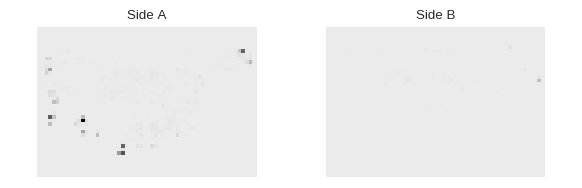

In [653]:
plotHeatmap([1751], 30, 40, 'Queen', "2016-08-20T08:00:00Z", "/storage/mi/aschle/2016_08_20_10h_8Uhr_95conf.db", cmap3)

(1200, 3)
(1200, 3)
(1200, 3)
(1200, 3)


/home/mi/aschle/miniconda3/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


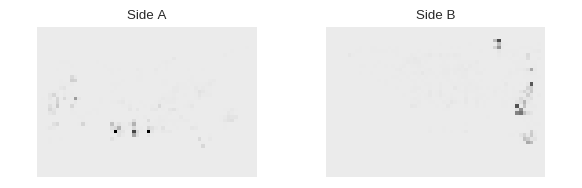

In [654]:
plotHeatmap([1751], 30, 40, 'Queen', "2016-08-22T08:00:00Z", "/storage/mi/aschle/2016_08_22_10h_8Uhr_95conf.db", cmap3)

(1200, 3)
(1200, 3)
(1200, 3)
(1200, 3)


/home/mi/aschle/miniconda3/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


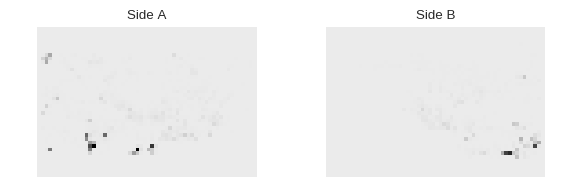

In [655]:
plotHeatmap([1751], 30, 40, 'Queen', "2016-08-24T08:00:00Z", "/storage/mi/aschle/2016_08_24_10h_8Uhr_95conf.db", cmap3)

In [1194]:
p1 = p[0][1]

In [1195]:
p2 = p[1][1]

In [1196]:
p3 = p[2][1]

(1200, 3)
(1200, 3)
(1200, 3)
(1200, 3)


/home/mi/aschle/miniconda3/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


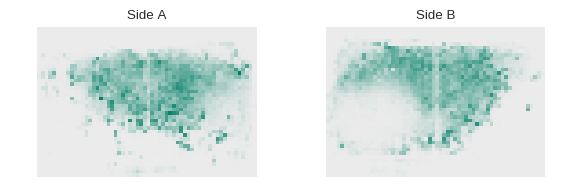

(1200, 3)
(1200, 3)
(1200, 3)
(1200, 3)


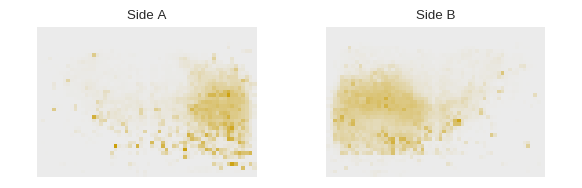

(1200, 3)
(1200, 3)
(1200, 3)
(1200, 3)


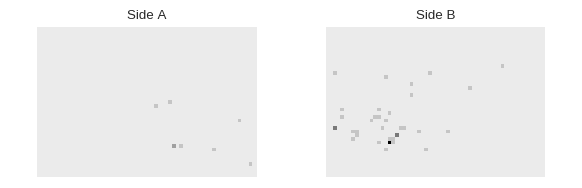

In [1176]:
cm = [cmap1, cmap2, cmap3]

for gr, group in p1.groupby(by='community'):
    plotHeatmap(list(group.id), 30,40, 'WalktrapN_network1', "2016-08-20T08:00:00Z", "/storage/mi/aschle/2016_08_20_10h_8Uhr_95conf.db", cm[gr])

(1200, 3)
(1200, 3)
(1200, 3)
(1200, 3)


/home/mi/aschle/miniconda3/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


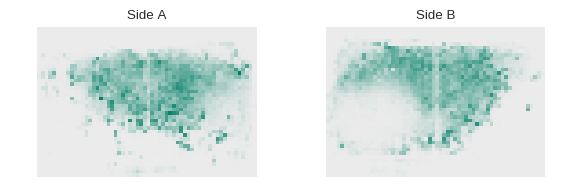

(1200, 3)
(1200, 3)
(1200, 3)
(1200, 3)


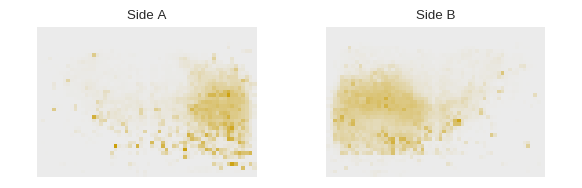

In [1197]:
cm = [cmap1, cmap2]

for gr, group in p1.groupby(by='community'):
    plotHeatmap(list(group.id), 30,40, 'LE_network1', "2016-08-20T08:00:00Z", "/storage/mi/aschle/2016_08_20_10h_8Uhr_95conf.db", cm[gr])

(1200, 3)
(1200, 3)
(1200, 3)
(1200, 3)


/home/mi/aschle/miniconda3/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


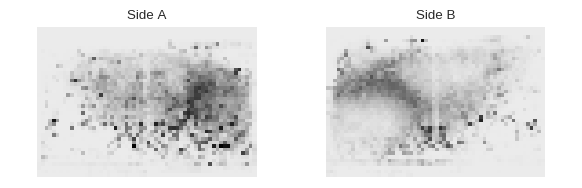

(1200, 3)
(1200, 3)
(1200, 3)
(1200, 3)


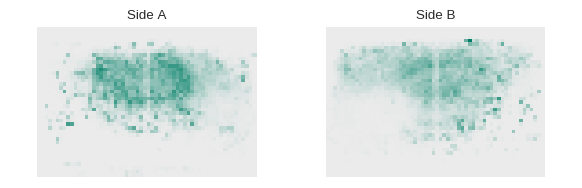

(1200, 3)
(1200, 3)
(1200, 3)
(1200, 3)


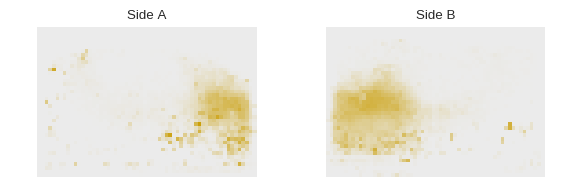

IndexError: list index out of range

In [1177]:
cm = [cmap3, cmap1, cmap2]
for gr, group in p2.groupby(by='community'):
    plotHeatmap(list(group.id), 30,40, 'WalktrapN_network2', "2016-08-22T08:00:00Z", "/storage/mi/aschle/2016_08_22_10h_8Uhr_95conf.db", cm[gr])

(1200, 3)
(1200, 3)
(1200, 3)
(1200, 3)


/home/mi/aschle/miniconda3/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


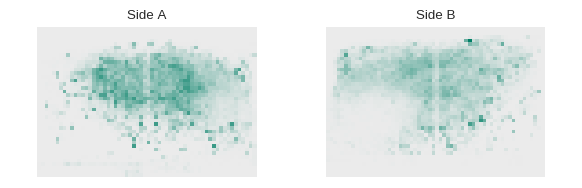

(1200, 3)
(1200, 3)
(1200, 3)
(1200, 3)


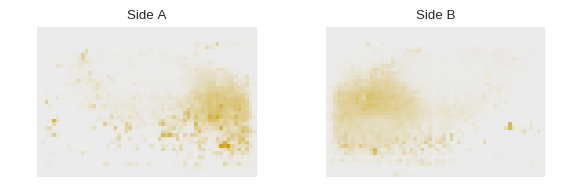

In [1198]:
cm = [cmap1, cmap2]
for gr, group in p2.groupby(by='community'):
    plotHeatmap(list(group.id), 30,40, 'LE_network2', "2016-08-22T08:00:00Z", "/storage/mi/aschle/2016_08_22_10h_8Uhr_95conf.db", cm[gr])

(1200, 3)
(1200, 3)
(1200, 3)
(1200, 3)


/home/mi/aschle/miniconda3/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


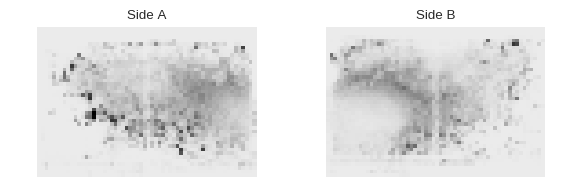

(1200, 3)
(1200, 3)
(1200, 3)
(1200, 3)


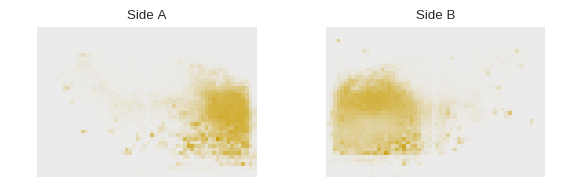

(1200, 3)
(1200, 3)
(1200, 3)
(1200, 3)


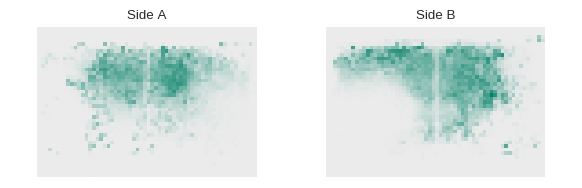

In [1178]:
cm = [cmap3, cmap2, cmap1]
for gr, group in p3.groupby(by='community'):
    plotHeatmap(list(group.id), 30,40, 'WalktrapN_network3', "2016-08-24T08:00:00Z", "/storage/mi/aschle/2016_08_24_10h_8Uhr_95conf.db", cm[gr])

(1200, 3)
(1200, 3)
(1200, 3)
(1200, 3)


/home/mi/aschle/miniconda3/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


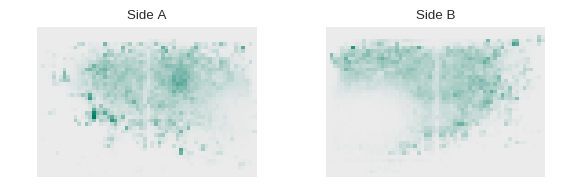

(1200, 3)
(1200, 3)
(1200, 3)
(1200, 3)


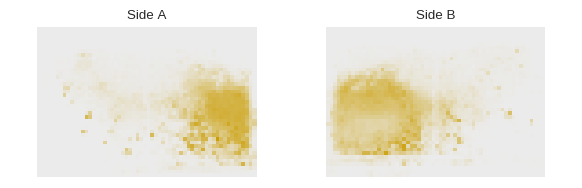

In [1199]:
cm = [cmap1, cmap2]
for gr, group in p3.groupby(by='community'):
    plotHeatmap(list(group.id), 30,40, 'LE_network3', "2016-08-24T08:00:00Z", "/storage/mi/aschle/2016_08_24_10h_8Uhr_95conf.db", cm[gr])

In [536]:
def getKDEdata(liste, xbins, ybins, txt, datestring, path):
    conn = sqlite3.connect(path)
    s = datetime.datetime.strptime(datestring, "%Y-%m-%dT%H:%M:%SZ").replace(tzinfo=pytz.UTC)
    e = s + datetime.timedelta(hours=10)
    
    datas = np.empty(4, dtype=object)

    for i in [0,1,2,3]:
        df = getBinnedData(liste, s.timestamp(), e.timestamp(), conn, i, xbins, ybins)
        
        dummy = DataFrame([(x,y) for x in list(range(xbins)) for y in list(range(ybins))], columns=['xbin', 'ybin'])
        data = dummy.merge(df, how='outer').fillna(0)

        if (i == 1 or i == 3):
            # mirrow horizontaly and  vertically
            data.xbin = xbins - data.xbin
            data.ybin = ybins - data.ybin
            # verschieben nach rechst, damit das am ende in einen Plot kommt
            data.xbin = data.xbin + xbins + 2
        
        datas[i] = data
    
    A = pd.concat([datas[0], datas[1]])
    B = pd.concat([datas[2], datas[3]])

    return A, B

In [538]:
p1 = p[0][1]

In [540]:
A0, B0 = getKDEdata(p1[p1.community == 0].id,
                    30,
                    40,
                    'X',
                    "2016-08-20T08:00:00Z",
                    "/storage/mi/aschle/2016_08_20_10h_8Uhr_95conf.db")

In [545]:
A1, B1 = getKDEdata(p1[p1.community == 1].id,
                    30,
                    40,
                    'X',
                    "2016-08-20T08:00:00Z",
                    "/storage/mi/aschle/2016_08_20_10h_8Uhr_95conf.db")

In [552]:
def plotKDE(final, txt):
    
    fig, ax = plt.subplots()
    fig.set_size_inches(5.91553,5.91553/3)
    ax.set_aspect('equal')
    
    tmp = []
    final[0].apply(lambda x: tmp.extend([(x.xbin, x.ybin) for i in list(range(int(int(x['count'])/50)))]), axis=1)
    x,y = zip(*tmp)
    sns.kdeplot(Series(x),Series(y), cmap="Reds", ax=ax, shade=True, shade_lowest=False)

    tmp = []
    final[1].apply(lambda x: tmp.extend([(x.xbin, x.ybin) for i in list(range(int(int(x['count'])/50)))]), axis=1)
    x,y = zip(*tmp)
    sns.kdeplot(Series(x),Series(y), cmap="Blues", ax=ax, shade=True, shade_lowest=False)
    
    plt.savefig('{}.pdf'.format(txt))
    plt.show()

/home/mi/aschle/miniconda3/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


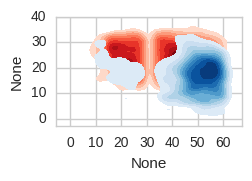

In [553]:
plotKDE([A0, A1], 'Side A')

/home/mi/aschle/miniconda3/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


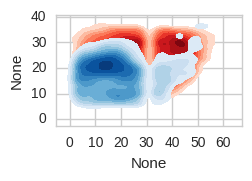

In [554]:
plotKDE([B0, B1], 'Side B')

# Alter Testen

In [154]:
def kolmogorovStest(df, by):
    gr = df.groupby(by=by)
    for g1, gr1 in gr:
        for g2, gr2 in gr:
            if g1>=g2:
                continue
            print(g1, g2,stats.ks_2samp(df.age[df[by] == g1], df.age[df[by] == g2]))

In [ ]:
def AgePerGroup(df, by):
    print("Total Mean: {}".format(df.age.mean()))
    
    df = df.query("age > -100 & age < 200")
    print("Mean after removal over very high and low: {}".format(df.age.mean()))

    df.age.hist(by=df[by], bins=15, range=(0,50))
    #plt.xlim([0,50])
    
    print("\nMean by community:")
    print(df.groupby(by=by).age.mean())

In [ ]:
AgePerGroup(t1, "community-le")

In [ ]:
AgePerGroup(t2, "community-le")

In [ ]:
AgePerGroup(t3, "community-le")

In [ ]:
for c in "fg le ml wt".split(' '):
    print(c)
    kolmogorovStest(t1, "community-{}".format(c))
    print("-")
    kolmogorovStest(t2, "community-{}".format(c))
    print("-")
    kolmogorovStest(t3, "community-{}".format(c))
    print('--------')

# Final - Community Stat - age

In [1086]:
import os

In [1290]:
# create DF with communities and age with leading eigenvector algo
def compareCommunitiesLE(g, datestr):
    
    lev = g.community_leading_eigenvector(weights='frequency')
    #lev = g.community_multilevel(weights="frequency")
    #lev = g.community_walktrap(weights="frequency")
    #lev_vc = lev.as_clustering(lev.optimal_count)
    #membership = lev_vc.membership
    
    ids = []
    membership = lev.membership
    
    for name, membership in zip(g.vs, membership):
        ids.append((int(name['id']), membership))

    ids = DataFrame(ids, columns=["id", "community"])
    
    start_dt = datetime.datetime.strptime(datestr, "%Y-%m-%d").replace(tzinfo=pytz.UTC)
    ids = addAge(ids, start_dt)

    return ids

In [1291]:
# create DF with communities and age with leading eigenvector algo
def compareCommunitiesWT(g, datestr):
    
    #lev = g.community_leading_eigenvector(weights='frequency')
    lev = g.community_multilevel(weights="frequency")
    lev = g.community_walktrap(weights="frequency")
    lev_vc = lev.as_clustering(lev.optimal_count)
    membership = lev_vc.membership
    
    ids = []
    #membership = lev.membership
    
    for name, membership in zip(g.vs, membership):
        ids.append((int(name['id']), membership))

    ids = DataFrame(ids, columns=["id", "community"])
    
    start_dt = datetime.datetime.strptime(datestr, "%Y-%m-%d").replace(tzinfo=pytz.UTC)
    ids = addAge(ids, start_dt)

    return ids

In [1292]:
#graph_files = os.listdir("networks/")
#pre = "nw/3ilen/"
pre = "networks/"
graph_files = os.listdir(pre)
graph_files = [g for g in graph_files if g.endswith('.graphml')]

In [1293]:
graph_files.sort()

In [1294]:
g_list = []
for f in [graph_files[4], graph_files[5], graph_files[6]]:
#for f in [graph_files[1], graph_files[3], graph_files[4]]:
    #g = thresholdedGraph(pre+f, 1)
    #g_list.append((f, g))
    g_list.append((f, ig.Graph.Read_GraphML(pre+f)))

In [1295]:
def getDFS(graph_liste):
    
    partsLE = np.empty(len(graph_liste), dtype=object)
    partsWT = np.empty(len(graph_liste), dtype=object)
    
    for e, (f, g) in enumerate(graph_liste):
        d = f.split("_")[-2]
        partsLE[e] = (d, compareCommunitiesLE(g, d))
        partsWT[e] = (d, compareCommunitiesWT(g, d))
    
    return partsLE, partsWT

In [1296]:
pLE, pWT = getDFS(g_list)

In [1274]:
sns.set_context("paper")

In [1275]:
def getQueen(df):
    
    gr = df.groupby(by="community")
    q = 1751
    c = None
    
    for i, group in gr:
        s = set(group.id.values)

        if q in s:
            c = i
    return c

In [1276]:
q = getQueen(p[0][1])

In [1277]:
q

0

In [1278]:
def getDFSstat(p):
    
    d_ = []
    n_ = []
    ngroups_ = []
    sizes_ = []
    ages_ =[]
    std_ =[]
    q_=[]
    
    for elem in p:
        d = elem[0]   
        df = elem[1]
        n = df.shape[0]
        ngroups = len(df.community.unique())
        sizes = df.groupby(by="community").size().apply(lambda x: (x, format(round(x/n*100,2), ".2f")+"%")).iloc[:].values
        ages = df.groupby(by="community").age.mean().apply(lambda x: format(round(x,2), ".2f")).iloc[:].values
        std = df.groupby(by="community").age.std().apply(lambda x: format(round(x,2), ".2f")).iloc[:].values
        d_.append(d)
        n_.append(n)
        ngroups_.append(ngroups)
        sizes_.append(sizes)
        ages_.append(ages)
        std_.append(std)
        q_.append(getQueen(df))
        
        
        
    return DataFrame([d_, sizes_, ages_, std_, q_], index=["date", "size", "ageMean", "std", "q"])

In [1279]:
df = getDFSstat(p)

In [1280]:
df = df.T

In [1285]:
df

,date,size,ageMean,std,q
0,2016-08-20,"[(434, 47.07%), (488, 52.93%)]","[16.81, 25.15]","[17.91, 19.49]",0
1,2016-08-22,"[(503, 51.43%), (475, 48.57%)]","[15.44, 26.37]","[19.54, 18.01]",0
2,2016-08-24,"[(385, 41.76%), (537, 58.24%)]","[12.85, 27.26]","[20.24, 17.84]",0


In [1218]:
print(df.to_latex())

\begin{tabular}{llllll}
\toprule
{} &        date &                                               size &                      ageMean &                         std &  q \\
\midrule
0 &  2016-08-20 &         [(431, 46.75\%), (490, 53.15\%), (1, 0.11\%)] &        [16.76, 25.16, 19.00] &         [17.92, 19.48, nan] &  0 \\
1 &  2016-08-22 &  [(311, 31.80\%), (372, 38.04\%), (294, 30.06\%), ... &  [23.11, 12.98, 28.15, 0.00] &  [19.48, 19.00, 16.77, nan] &  1 \\
2 &  2016-08-24 &      [(301, 32.65\%), (390, 42.30\%), (231, 25.05\%)] &         [23.83, 27.63, 7.09] &       [17.22, 18.48, 19.60] &  2 \\
\bottomrule
\end{tabular}



/home/mi/aschle/miniconda3/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


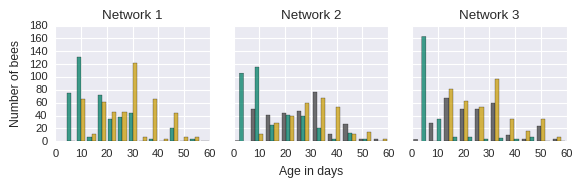

In [1235]:
fig, axn = plt.subplots(ncols=3, sharey=True, sharex=True)
fig.set_size_inches(5.91553,5.91553/3)
sns.set_style('darkgrid')
sns.set_context("paper")

bins = [15, 10, 10]
col = [['#007f66', '#CB9F0A'],['#404040', '#007f66', '#CB9F0A'],['#404040','#CB9F0A', '#007f66']]

for i, ax in enumerate(axn.flat):
    df = p[i][1]
    df = df.query("age > -100 & age < 200")
    gr = list(df.groupby(by="community").age)
    gr = [b for a,b in gr if len(b) > 1]
    #ax.hist(gr, bins=15, alpha=0.75, range=(0,60), color=['#007f66', '#CB9F0A'])
    ax.hist(gr, bins=bins[i], alpha=0.75, range=(0,60), color=col[i])
    ax.set_title("Network {}".format(i+1))
    
    if (i == 0):
        ax.set_ylabel('Number of bees')
    if (i == 1):
        ax.set_xlabel('Age in days')

#plt.subplots_adjust(top=0.7)

#fig.suptitle("Age Distribution per Community")
fig.tight_layout()
#plt.savefig('ageDistribution-LE.pdf')
plt.savefig('ageDistribution-WT.pdf')

In [1286]:
def kolmogorovStest2(df, by):
    stat = []
    gr = df.groupby(by=by)
    gr = [(a,b) for a,b in gr if (len(b) > 1)]
    for g1, gr1 in gr:
        for g2, gr2 in gr:
            if g1>=g2:
                continue
            if (len(gr1) > 1 and len(gr2 > 1)):
                stat.append((g1, g2, gr1.age.mean(), gr2.age.mean(), (stats.ks_2samp(df.age[df[by] == g1], df.age[df[by] == g2])[1])))
    return stat

In [1288]:
stat = []
for elem in p:
    stat.extend(kolmogorovStest2(elem[1], "community"))

In [1284]:
Series(stat).std()

TypeError: setting an array element with a sequence.

In [1289]:
stat

[(0, 1, 16.806451612903224, 25.149590163934427, 5.097938263750467e-32),
 (0, 1, 15.441351888667992, 26.366315789473685, 7.6085058287684828e-38),
 (0, 1, 12.846753246753247, 27.264432029795159, 1.371178930475484e-64)]

# Centrality Measures

In [1302]:
stat20 = pd.read_csv('centrality-age-20.csv')
stat22 = pd.read_csv('centrality-age-22.csv')
stat24 = pd.read_csv('centrality-age-24.csv')

In [1305]:
pLE[0][1].head()

,id,community,age
0,3041,0,19
1,1291,0,9
2,563,0,10
3,714,1,18
4,2755,1,44


In [1346]:
df20 = stat20.merge(pWT[0][1])

In [1347]:
df22= stat22.merge(pWT[1][1])

In [1348]:
df24 = stat24.merge(pWT[2][1])

In [1349]:
df20.head()

,Unnamed: 0,id,age,degree,strength,lcc,lccF,lccFinv,between,betweenF,betweenFinv,closeness,closenessF,closenessFinv,evc,evcF,evcFinv,community
0,0,4058,10,600,3205,0.801503,0.013310,0.219118,0.000261,0.001216,0.000002,0.741546,0.535777,14.777992,0.030226,0.013797,0.037600,1
1,1,450,47,190,440,0.851351,0.007891,0.375235,0.000015,0.001219,0.000000,0.557169,0.532370,11.007958,0.009946,0.002063,0.021655,1
2,2,3701,31,805,8588,0.763907,0.020142,0.132705,0.000590,0.000408,0.000716,0.888139,0.519166,19.047570,0.039967,0.038616,0.027692,1
3,3,3017,19,277,1041,0.845681,0.010799,0.287508,0.000038,0.000814,0.000000,0.588123,0.526888,12.666333,0.014326,0.005013,0.023165,0
4,4,724,5,668,8957,0.813976,0.023500,0.154215,0.000414,0.000638,0.005075,0.783830,0.523593,20.975982,0.034027,0.052628,0.029206,0


0         Axes(0.1,0.559091;0.363636x0.340909)
1    Axes(0.536364,0.559091;0.363636x0.340909)
2             Axes(0.1,0.15;0.363636x0.340909)
3        Axes(0.536364,0.15;0.363636x0.340909)
dtype: object

/home/mi/aschle/miniconda3/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


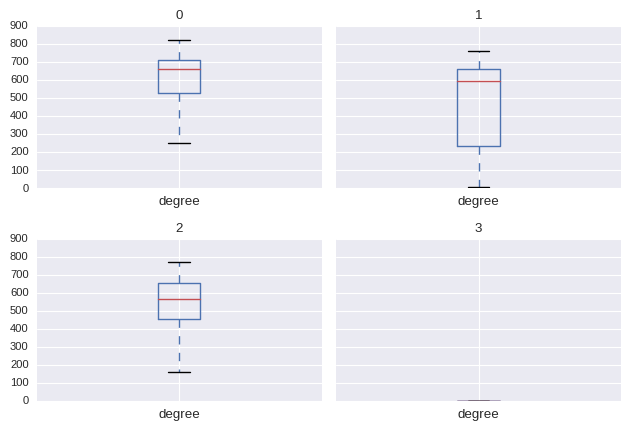

In [1357]:
df22.groupby(by='community').boxplot(column=['degree'])

In [1359]:
df24.groupby(by='community').boxplot(column=['ev'])

KeyError: "['ev'] not in index"

AttributeError: 'NoneType' object has no attribute 'is_bbox'